In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, Dropout

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import datetime

In [ ]:
log_dir = "logs/"
BATCH_SIZE = 32
BUFFER_SIZE = 1000
images_shape = [224, 224, 3]
images_size = (224, 224)
input_size = (224, 224, 3)
embedding_size = 64
class_count = 2
EPOCHS = 2

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-05-08 23:30:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.48.252, 2600:1413:1:597::317f, 2600:1413:1:5a0::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.48.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   272MB/s    in 2.9s    

2023-05-08 23:31:00 (272 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip -q kagglecatsanddogs_5340.zip

# VGG16

## Load Data

In [ ]:
x = []
y = []
for i in range(12500):
    name = './PetImages/Cat/%d.jpg' % i
    try : 
        img = cv2.imread(name)
        img = cv2.resize(img , (224,224))
        # img = np.reshape(img , (2500,))
        x.append(img)
        y.append(0)
    except : 
        pass
for i in range(12500):
    name = './PetImages/Dog/%d.jpg' % i
    try : 
        img = cv2.imread(name)
        img = cv2.resize(img, (224,224))
        # img = np.reshape(img , (2500,))
        x.append(img)
        y.append(1)
    except : 
        pass
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(24946, 224, 224, 3)
(24946,)


In [ ]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train, y_test = train_test_split(x,y, random_state=42 , test_size=0.5)

In [ ]:
del x
del y

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_data.shuffle(5000).batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds = test_data.shuffle(5000).batch(BATCH_SIZE)

In [ ]:
del train_data
del test_data

In [ ]:
del x_train
del x_test

In [ ]:
del y_train
del y_test

## Build Base Model (VGG16)

In [ ]:
base_model_vgg = tf.keras.applications.VGG16(input_shape=images_shape,
                                         include_top=False,
                                         weights='imagenet')
base_model_vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
len(base_model_vgg.layers)

19

In [ ]:
preprocess_input_vgg = tf.keras.applications.vgg16.preprocess_input

## 10% Frozen




### Build Model

In [ ]:
for layer in base_model_vgg.layers[:-8]:
  print(layer)

In [ ]:
for layer in base_model_vgg.layers[:-8]:
  layer.trainable = False

base_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_vgg(inputs)
model = base_model_vgg(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

### Train

In [ ]:
model.save('models/vgg16-30%-frozen.h5')

In [ ]:
logdir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 160s 362ms/step - loss: 0.3279 - accuracy: 0.8672 - val_loss: 0.0911 - val_accuracy: 0.9662
Epoch 2/2
390/390 [==============================] - 133s 341ms/step - loss: 0.0866 - accuracy: 0.9662 - val_loss: 0.0837 - val_accuracy: 0.9724


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

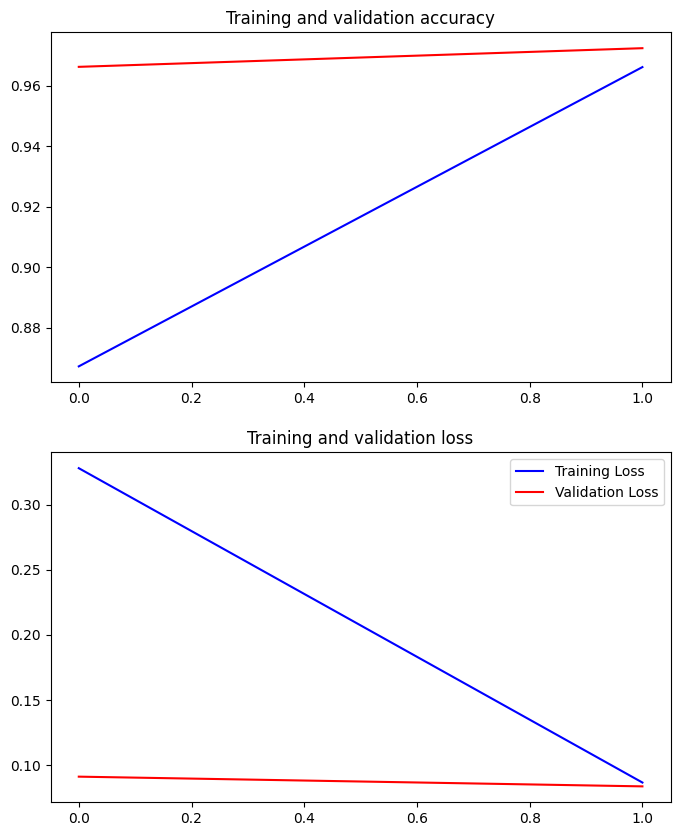

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

### Random Forest Classifier

In [ ]:
feature_extractor_model = tf.keras.Model(inputs, feature)
feature_extractor_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                           

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)

In [ ]:
for images, labels in train_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  rf_classifier.fit(X=features, y=labels)

In [ ]:
prediction_rf = np.array([])
y_val = np.array([])
for images, labels in val_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  prediction = rf_classifier.predict(X=features)
  prediction_rf = np.concatenate([prediction_rf, prediction], axis=0)
  y_val = np.concatenate([y_val, labels], axis=0)

In [ ]:
print('Accuracy =', metrics.accuracy_score(y_val, prediction_rf))

Accuracy = 0.952938346829151


## 30% Frozen




### Build Model

In [ ]:
for layer in base_model_vgg.layers[:-6]:
  layer.trainable = False

base_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_vgg(inputs)
model = base_model_vgg(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422

### Train

In [ ]:
model.save('models/vgg16-30%-frozen.h5')

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 123s 305ms/step - loss: 0.0773 - accuracy: 0.9715 - val_loss: 0.0794 - val_accuracy: 0.9738
Epoch 2/2
390/390 [==============================] - 149s 381ms/step - loss: 0.0427 - accuracy: 0.9840 - val_loss: 0.0731 - val_accuracy: 0.9773


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

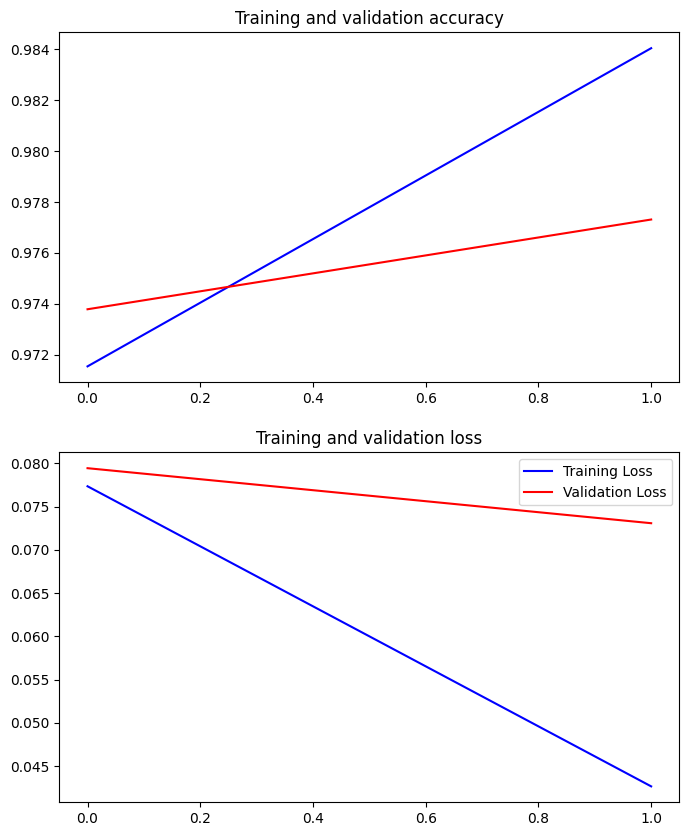

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Random Forest Classifier

In [ ]:
feature_extractor_model = tf.keras.Model(inputs, feature)
feature_extractor_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)

In [ ]:
for images, labels in train_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  rf_classifier.fit(X=features, y=labels)

In [ ]:
prediction_rf = np.array([])
y_val = np.array([])
for images, labels in val_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  prediction = rf_classifier.predict(features)
  prediction_rf = np.concatenate([prediction_rf, prediction], axis=0)
  y_val = np.concatenate([y_val, labels], axis=0)

In [ ]:
print('Accuracy =', metrics.accuracy_score(y_val, prediction_rf))

Accuracy = 0.9594323739276838


In [ ]:
del prediction_rf 
del y_val

## 50% Frozen




### Build Model

In [ ]:
for layer in base_model_vgg.layers[:-4]:
  layer.trainable = False

base_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_vgg(inputs)
model = base_model_vgg(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422

### Train

In [ ]:
model.save('models/vgg16-50%-frozen.h5')

In [ ]:
logdir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds  
      )

Epoch 1/2
390/390 [==============================] - 118s 294ms/step - loss: 0.0569 - accuracy: 0.9856 - val_loss: 0.2871 - val_accuracy: 0.9618
Epoch 2/2
390/390 [==============================] - 113s 289ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.1372 - val_accuracy: 0.9792


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

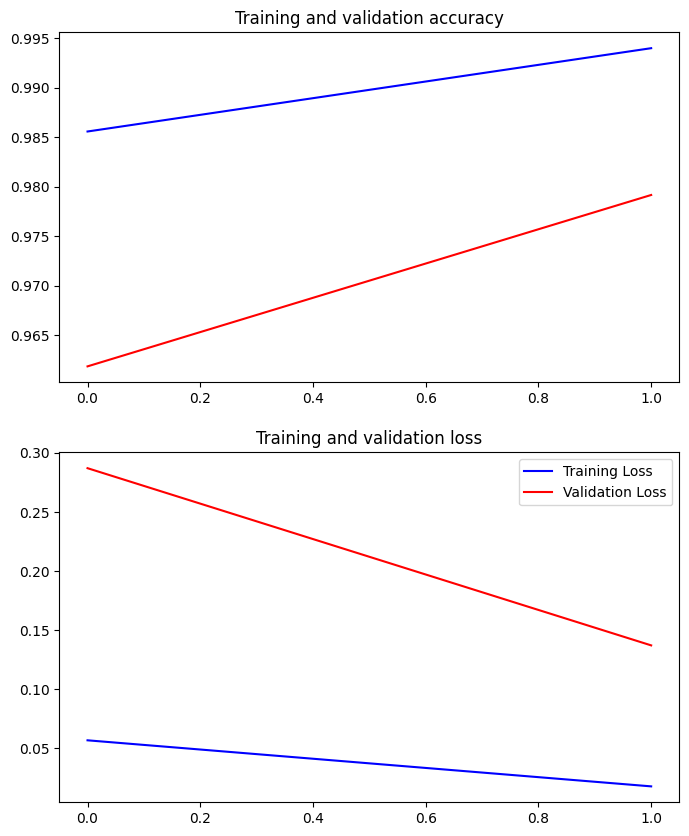

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Random Forest Classifier

In [ ]:
feature_extractor_model = tf.keras.Model(inputs, feature)
feature_extractor_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)

In [ ]:
for images, labels in train_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  rf_classifier.fit(X=features, y=labels)

In [ ]:
prediction_rf = np.array([])
y_val = np.array([])
for images, labels in val_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  prediction = rf_classifier.predict(X=features)
  prediction_rf = np.concatenate([prediction_rf, prediction], axis=0)
  y_val = np.concatenate([y_val, labels], axis=0)

In [ ]:
print('Accuracy =', metrics.accuracy_score(y_val, prediction_rf))

Accuracy = 0.9365830193217349


## 70% frozen


### Build Model

In [ ]:
for layer in base_model_vgg.layers[:-3]:
  layer.trainable = False

base_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_vgg(inputs)
model = base_model_vgg(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               6422

### Train

In [ ]:
model.save('models/vgg16-70%-frozen.h5')

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 112s 282ms/step - loss: 0.0302 - accuracy: 0.9937 - val_loss: 0.1228 - val_accuracy: 0.9827
Epoch 2/2
390/390 [==============================] - 110s 281ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.1498 - val_accuracy: 0.9811


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

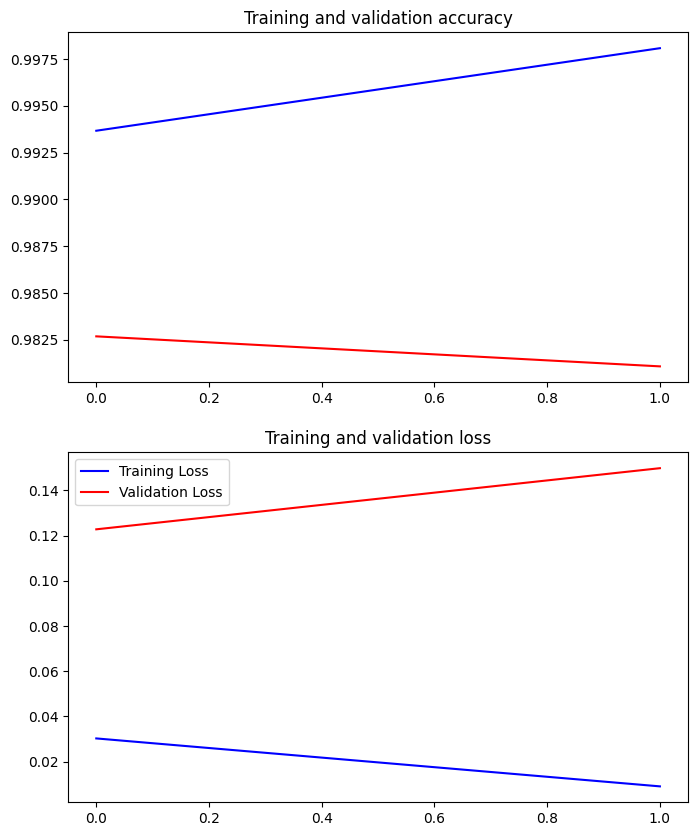

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

### Random Forest Classifier

In [ ]:
feature_extractor_model = tf.keras.Model(inputs, feature)
feature_extractor_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                           

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)

In [ ]:
for images, labels in train_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  rf_classifier.fit(X=features, y=labels)

In [ ]:
prediction_rf = np.array([])
y_val = np.array([])
for images, labels in val_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  prediction = rf_classifier.predict(X=features)
  prediction_rf = np.concatenate([prediction_rf, prediction], axis=0)
  y_val = np.concatenate([y_val, labels], axis=0)

In [ ]:
print('Accuracy =', metrics.accuracy_score(y_val, prediction_rf))

Accuracy = 0.952938346829151


#ResNet50

## Build Base Model (ResNet50)

In [ ]:
base_model_resnet = tf.keras.applications.ResNet50(input_shape=images_shape,
                                         include_top=False,
                                         weights='imagenet')
base_model_resnet.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
len(base_model_resnet.layers)

175

In [ ]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input

## 10% Frozen




### Build Model

In [ ]:
for layer in base_model_resnet.layers[:-82]:
  layer.trainable = False

base_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_resnet(inputs)
model = base_model_resnet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               2569

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 112s 286ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0905 - val_accuracy: 0.9832
Epoch 2/2
390/390 [==============================] - 111s 284ms/step - loss: 0.0187 - accuracy: 0.9951 - val_loss: 0.0951 - val_accuracy: 0.9815


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

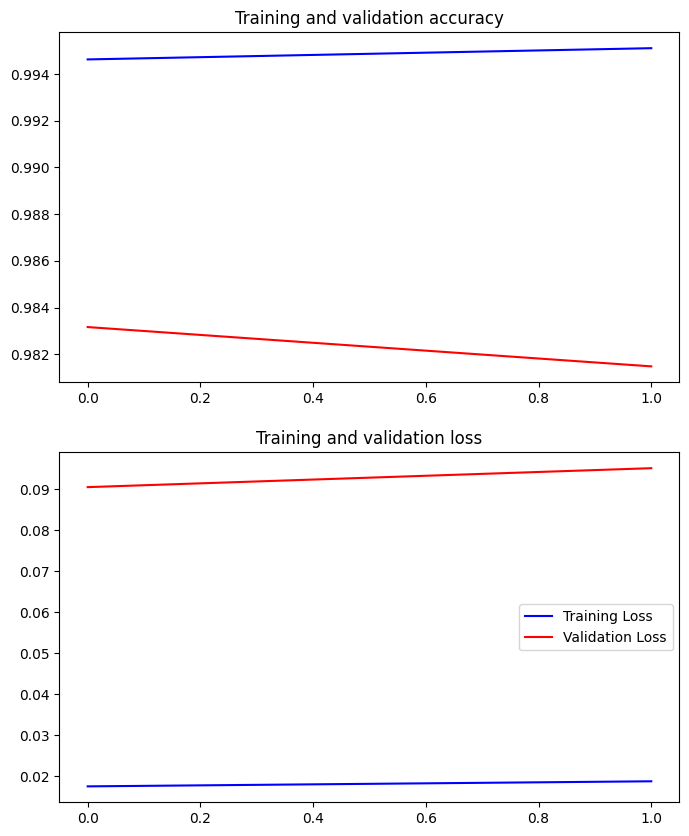

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

## 30% Frozen

### Build Model

In [ ]:
for layer in base_model_resnet.layers[:-42]:
  layer.trainable = False

base_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_resnet(inputs)
model = base_model_resnet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               2569

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 109s 251ms/step - loss: 0.0343 - accuracy: 0.9912 - val_loss: 0.0794 - val_accuracy: 0.9840
Epoch 2/2
390/390 [==============================] - 96s 245ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.1257 - val_accuracy: 0.9825


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

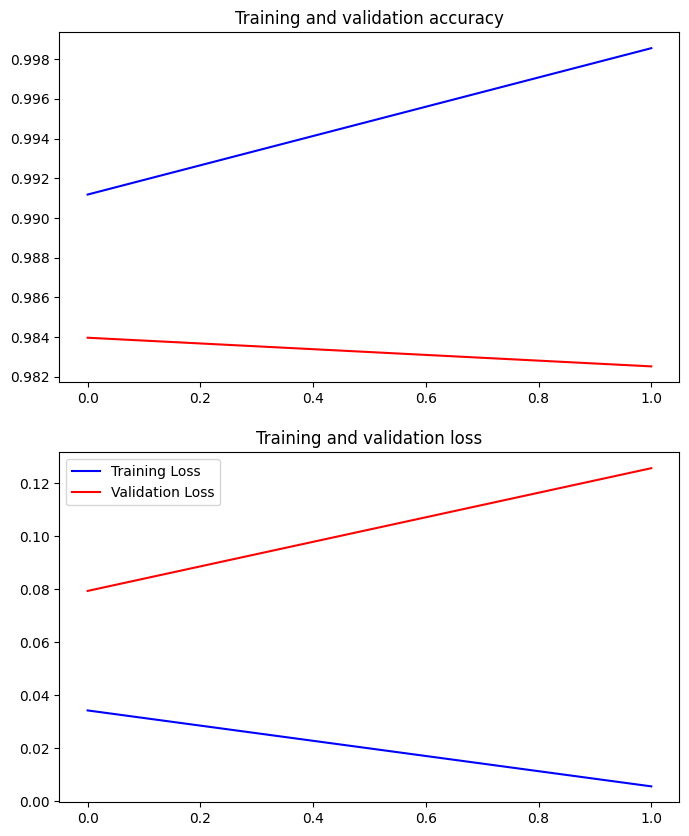

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

### Random Forest Classifier

In [ ]:
feature_extractor_model = tf.keras.Model(inputs, feature)
feature_extractor_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               256

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)

In [ ]:
for images, labels in train_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  rf_classifier.fit(X=features, y=labels)

In [ ]:
prediction_rf = np.array([])
y_val = np.array([])
for images, labels in val_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  prediction = rf_classifier.predict(X=features)
  prediction_rf = np.concatenate([prediction_rf, prediction], axis=0)
  y_val = np.concatenate([y_val, labels], axis=0)

In [ ]:
print('Accuracy =', metrics.accuracy_score(y_val, prediction_rf))

Accuracy = 0.9765894331756594


In [ ]:
del prediction_rf
del y_val

## 50% Frozen




### Build Model

In [ ]:
for layer in base_model_resnet.layers[:-26]:
  layer.trainable = False

base_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_resnet(inputs)
model = base_model_resnet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_9   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               256

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 98s 230ms/step - loss: 0.0099 - accuracy: 0.9959 - val_loss: 0.0963 - val_accuracy: 0.9846
Epoch 2/2
390/390 [==============================] - 89s 228ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0977 - val_accuracy: 0.9865


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

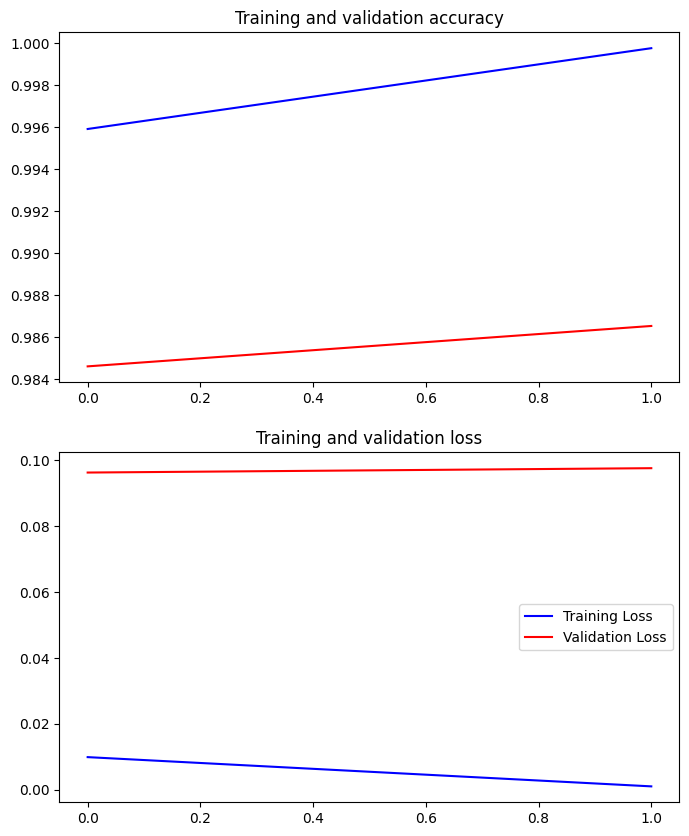

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

## 70% Frozen




### Build Model

In [ ]:
for layer in base_model_resnet.layers[:-17]:
  layer.trainable = False

base_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_resnet(inputs)
model = base_model_resnet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_10  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_10 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               256

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 93s 218ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0862 - val_accuracy: 0.9877
Epoch 2/2
390/390 [==============================] - 84s 215ms/step - loss: 4.9974e-05 - accuracy: 1.0000 - val_loss: 0.0933 - val_accuracy: 0.9874


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

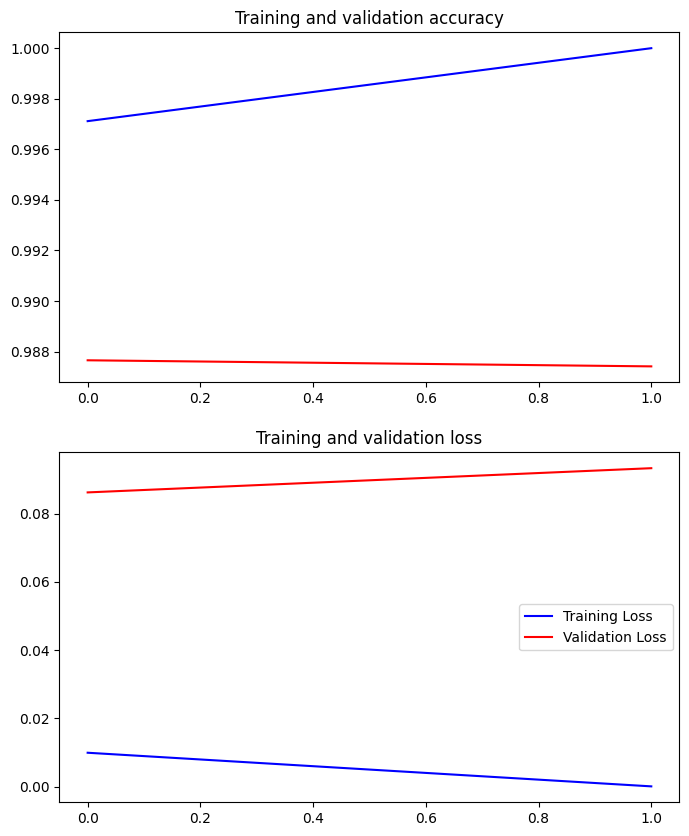

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

#DenseNet121

## Build Base Model (DenseNet121)






In [ ]:
base_model_densenet = tf.keras.applications.DenseNet121(input_shape=images_shape,
                                         include_top=False,
                                         weights='imagenet')
base_model_densenet.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
len(base_model_densenet.layers)

427

In [ ]:
preprocess_input_densenet = tf.keras.applications.densenet.preprocess_input

## 10% Frozen




### Build Model

In [ ]:
for layer in base_model_densenet.layers[:-330]:
  layer.trainable = False

base_model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_densenet(inputs)
model = base_model_densenet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 202s 321ms/step - loss: 0.0952 - accuracy: 0.9671 - val_loss: 0.0327 - val_accuracy: 0.9893
Epoch 2/2
390/390 [==============================] - 119s 304ms/step - loss: 0.0276 - accuracy: 0.9900 - val_loss: 0.0313 - val_accuracy: 0.9888


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

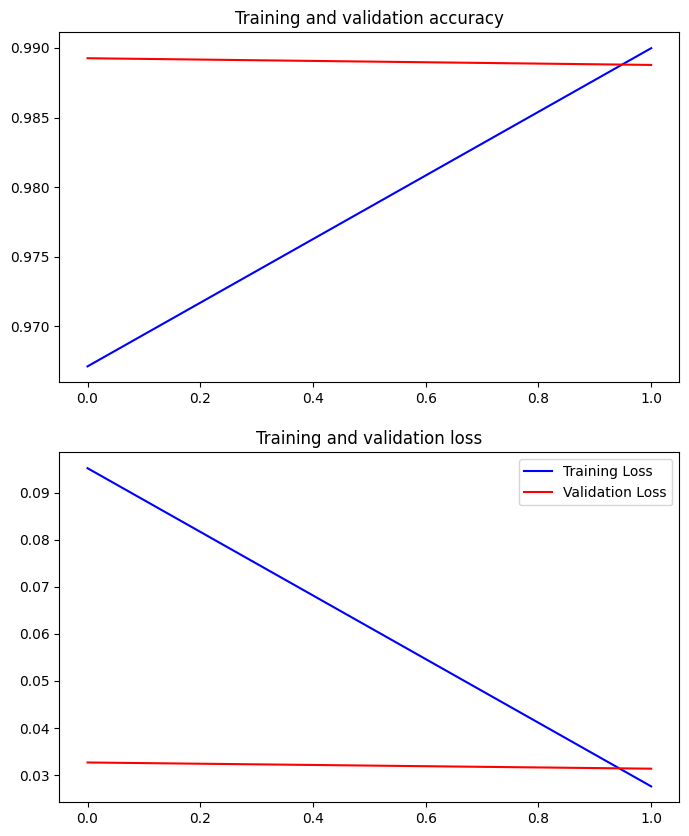

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

## 30% Frozen




### Build Model

In [ ]:
for layer in base_model_densenet.layers[:-225]:
  layer.trainable = False

base_model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_densenet(inputs)
model = base_model_densenet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 141s 258ms/step - loss: 0.0387 - accuracy: 0.9889 - val_loss: 0.0402 - val_accuracy: 0.9893
Epoch 2/2
390/390 [==============================] - 98s 251ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.1201 - val_accuracy: 0.9723


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

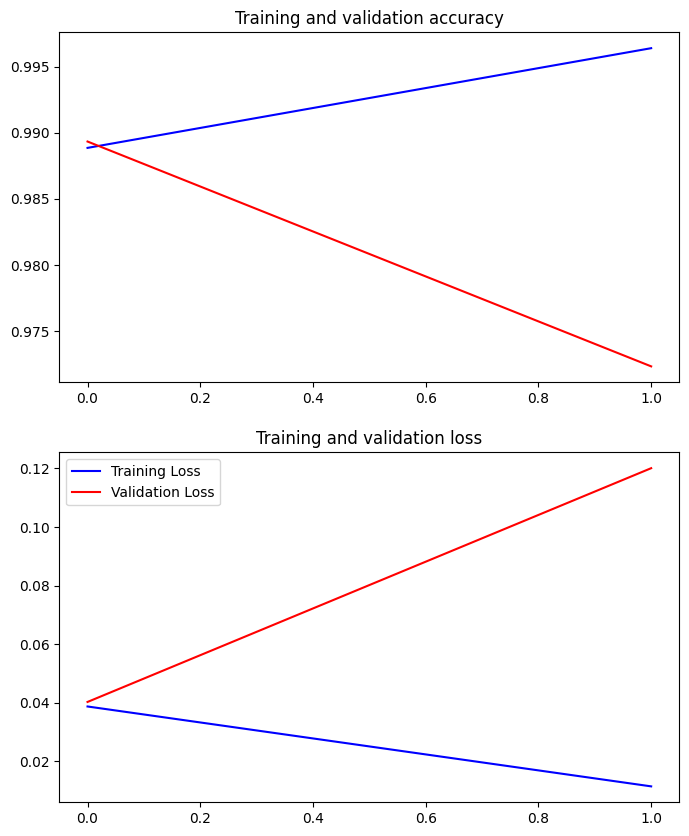

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

### Random Forest Classifier

In [ ]:
feature_extractor_model = tf.keras.Model(inputs, feature)
feature_extractor_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_12 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)

In [ ]:
for images, labels in train_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  rf_classifier.fit(X=features, y=labels)

In [ ]:
prediction_rf = np.array([])
y_val = np.array([])
for images, labels in val_ds:
  features = feature_extractor_model.predict(images, verbose=0)
  prediction = rf_classifier.predict(X=features)
  prediction_rf = np.concatenate([prediction_rf, prediction], axis=0)
  y_val = np.concatenate([y_val, labels], axis=0)

In [ ]:
print('Accuracy =', metrics.accuracy_score(y_val, prediction_rf))

Accuracy = 0.9890162751543333


In [ ]:
del prediction_rf
del y_val

## 50% Frozen




### Build Model

In [ ]:
for layer in base_model_densenet.layers[:-146]:
  layer.trainable = False

base_model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_densenet(inputs)
model = base_model_densenet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_13 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 115s 226ms/step - loss: 0.0156 - accuracy: 0.9958 - val_loss: 0.0515 - val_accuracy: 0.9921
Epoch 2/2
390/390 [==============================] - 86s 221ms/step - loss: 0.0087 - accuracy: 0.9981 - val_loss: 0.0708 - val_accuracy: 0.9909


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

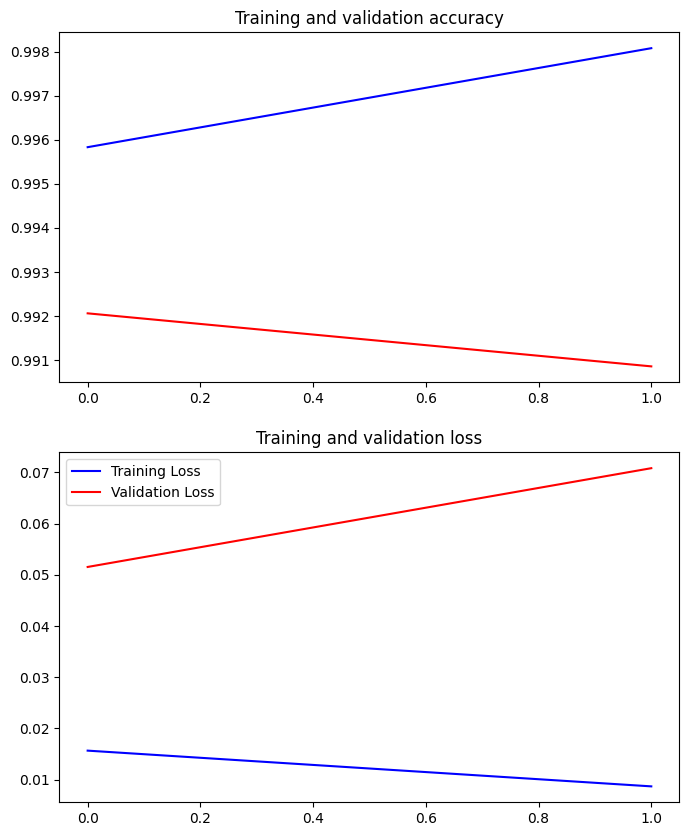

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history

## 70% Frozen




### Build Model

In [ ]:
for layer in base_model_densenet.layers[:-107]:
  layer.trainable = False

base_model_densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
inputs = tf.keras.Input(shape=input_size)
model = preprocess_input_densenet(inputs)
model = base_model_densenet(model)

model = layers.Flatten()(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.5)(model)

feature = layers.Dense(64, activation=None, name='feature')(model)

activation = tf.keras.layers.Activation('relu')(feature)
outputs = layers.Dense(1, name='classification')(activation)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss={'classification': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              metrics=['accuracy'])

model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_14 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                          

### Train

In [ ]:
history = model.fit(
      train_ds,  
      epochs=EPOCHS,
      validation_data=val_ds
      )

Epoch 1/2
390/390 [==============================] - 103s 208ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0614 - val_accuracy: 0.9916
Epoch 2/2
390/390 [==============================] - 79s 203ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0567 - val_accuracy: 0.9918


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

### Plot Results

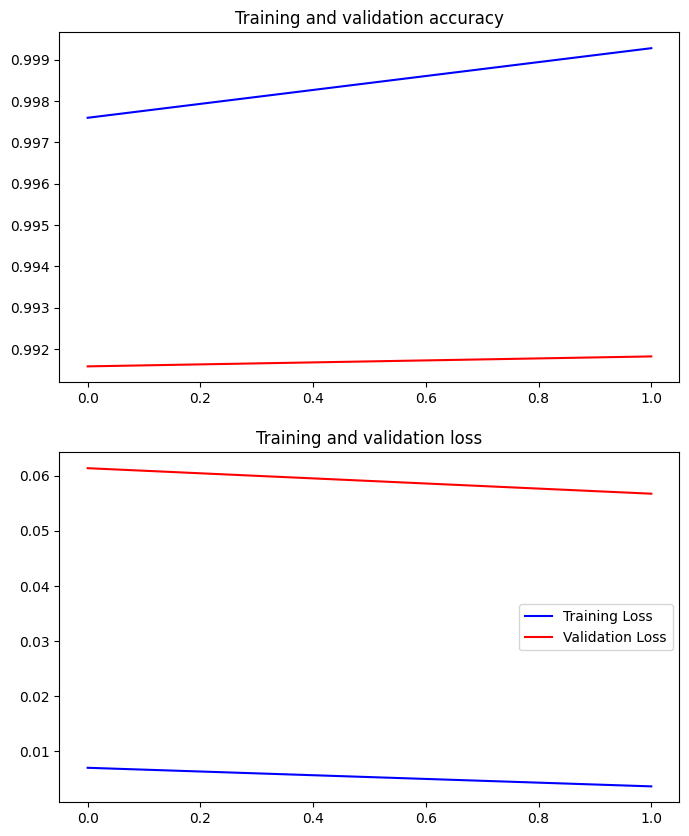

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
del history